# Dataset Loading: Introduction

In this section, we will be loading the `PTB-XL` dataset for the purpose of exploration and analysis.

## Dataset Loading: Import Statements

In [1]:
from os.path import exists
import pandas as pd
import numpy as np
import pickle
import wfdb
import ast

## Dataset Loading: The Code

In [2]:
if exists('dataset.npz'):
    X, Y = pickle.load(open('dataset.npz', 'rb'))
else:
    # REF: https://physionet.org/files/ptb-xl/1.0.2/example_physionet.py
    
    def load_raw_data(df, sampling_rate, path):
        if sampling_rate == 100:
            data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        else:
            data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
        return data

    path = 'physionet.org/files/ptb-xl/1.0.2/'
    sampling_rate=100

    # load and convert annotation data
    Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    # Load raw signal data
    X = load_raw_data(Y, sampling_rate, path)

    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))

    # Apply diagnostic superclass
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
    Y = Y.astype({'patient_id': int, 'age': int, 'device': 'category'})

    pickle.dump([X, Y], open('dataset.npz', 'wb'))

Y

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,QRS-CLBB,ST-ELEV-MI,ST-DEPR-MI,Q-ISC,Q-ISC-QPeak,Q-ISC-V2V3,Q-ISC-RPeak,STRAIN,MI-ALL,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709,56,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,False,False,False,False,False,False,False,False,False,[NORM]
2,13243,19,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
3,20372,37,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
4,17014,24,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
5,17448,19,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180,67,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,False,False,True,False,False,False,False,False,True,[STTC]
21834,20703,300,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,False,False,False,False,False,False,False,False,False,[NORM]
21835,19311,59,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,False,False,False,False,False,False,False,False,False,[STTC]


# Displaying the Signals: Introduction

In this section, we will display the patient information and signals in a way that can be easily analyzed by a doctor.

## Displaying the Signals: Import Statements

In [3]:
from copy import deepcopy as dc
from scipy import signal
import ipywidgets as widgets
import matplotlib.pyplot as plt
import heartpy as hp

%matplotlib inline
plt.rcParams['figure.dpi'] = 300

## Displaying the Signals: Helper Functions

In [4]:
def denoise_signal(data, fs=100):
    """
    Denoise the 1D signal
    # REF: https://medium.com/mlearning-ai/denoising-ecg-signals-with-ensemble-of-filters-65919d15afe9
    
    Parameters:
    data: 1D signal to be denoised
    
    fs: The sampling rate of the signal
    
    Returns:
    The denoised 1D signal
    """
    
    b, a = hp.filtering.butter_highpass(.5, fs)
    return signal.filtfilt(b, a, data)


def find_peaks(data):
    """
    Detect peaks of the ECG signal
    # REF: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

    Parameters:
    data: 1D signal with peaks

    Returns:
    An array containing the location of the peaks
    """

    return signal.find_peaks(data, distance=50)[0]


def scale_signal(data):
    """
    Scale the signal if it is so high that intersects with other signals in the plot
    
    Parameters:
    data: 1D signal to be scaled
    
    Returns:
    The scaled 1D signal
    """

    minim, maxim = data.min(), data.max()
    peak = max(abs(minim), abs(maxim))
    if peak > .9: data = (data / peak) * .9
    return data

## Displaying the Signals: The Code

In [5]:
# REF: https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html

widget_selectid = widgets.IntText(
    value=0,
    min=0,
    max=Y.shape[0],
    description='Record Idx',
)

widget_apply = widgets.Button(
    description='Show',
)

widget_save = widgets.Button(
    description='Save',
)

widget_plot = widgets.Output()

ui = widgets.VBox([
    widgets.HBox([widget_selectid, widget_apply, widget_save]),
    widget_plot
])

def plot_ecg(ax, data, info):
    """
    Plot the given ECG signal and info on the given ax
    
    Parameters:
    ax: The Matplotlib ax to plot the data
    
    data: The 2D array of 12 signals to be plotted
    
    info: Metadata of the patient to be shown
    """
    
    data = dc(data)
    
    for row in data:
        row[:] = denoise_signal(row)
        row[:] = scale_signal(row)

    length = data.shape[1]
    X = np.arange(length) + 1

    for i in range(6):
        ax.plot(X + 75, data[i] + (5-i)*2+1, color='black', lw=.8)

    for i in range(6):
        ax.plot(X + 150 + length, data[i+6] + (5-i)*2+1, color='black', lw=.8)
    
    peaks = find_peaks(-data[6])
    ax.vlines(peaks+75, 0, 12.5, color='blue', alpha=.5, linestyles='dashed', lw=1)
    ax.vlines(peaks+150+length, 0, 12.5, color='blue', alpha=.5, linestyles='dashed', lw=1)

    ax.grid(which='both')
    ax.grid(which='major', alpha=0.15, color='darkred')
    
    xticks = np.arange(0, 2 * length + 150, 20)
    yticks = np.arange(0, 17, .5)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(np.zeros(len(xticks), dtype=str))
    ax.set_yticklabels(np.zeros(len(yticks), dtype=str))
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.set_xlim([xticks[0]-20, xticks[-1]+20])
    ax.set_ylim([yticks[0], yticks[-1]])
    ax.spines['bottom'].set_color('darkred')
    ax.spines['right'].set_color('darkred')
    ax.spines['left'].set_color('darkred')
    ax.spines['top'].set_color('darkred')
    
    ax.text(0, 11, 'I')
    ax.text(0, 9, 'II')
    ax.text(0, 7, 'III')
    ax.text(0, 5, 'aVL')
    ax.text(0, 3, 'aVR')
    ax.text(0, 1, 'aVF')
    
    ax.text(length+90, 11, 'V1')
    ax.text(length+90, 9, 'V2')
    ax.text(length+90, 7, 'V3')
    ax.text(length+90, 5, 'V4')
    ax.text(length+90, 3, 'V5')
    ax.text(length+90, 1, 'V6')
    
    ax.text(0, 15, 'Patient ID: ' + str(info.patient_id))
    ax.text(0, 14, 'Recording Date: ' + str(info.recording_date))
    ax.text(0, 13, 'Heart Beat: ' + str(len(peaks) * 6) + ' bpm')

    ax.text(1000, 15, 'Sex: ' + str(info.sex))
    ax.text(1000, 14, 'Height: ' + str(info.height))
    ax.text(1000, 13, 'Weight: ' + str(info.weight))

    ax.text(1500, 15, 'Nurse: ' + str(info.nurse))
    ax.text(1500, 14, 'Site: ' + str(info.site))
    ax.text(1500, 13, 'Device: ' + str(info.device))

main_figure = None

def change_row(_):
    """
    Create a new plot using the given row id
    """
    
    rowid = widget_selectid.value
    
    global main_figure

    with widget_plot:
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        main_figure = fig
        plot_ecg(ax, X[rowid].T, Y.iloc[rowid])
        widget_plot.clear_output()
        fig.tight_layout(pad=0)
        plt.show()

        
def save_panel(_):
    """
    Save the created figure to hard drive
    """

    global main_figure
    if main_figure is not None:
        main_figure.savefig('ecg-panel.png')

widget_apply.on_click(change_row)
widget_apply.on_click(save_panel)
display(ui);

# Statistical Analysis: Introduction

In this section, we will do a little statistical analysis of the dataset and patient information.

## Statistical Analysis: Import Statements

In [6]:
import seaborn as sns
from scipy.stats import ttest_ind

## Statistical Analysis: The Code

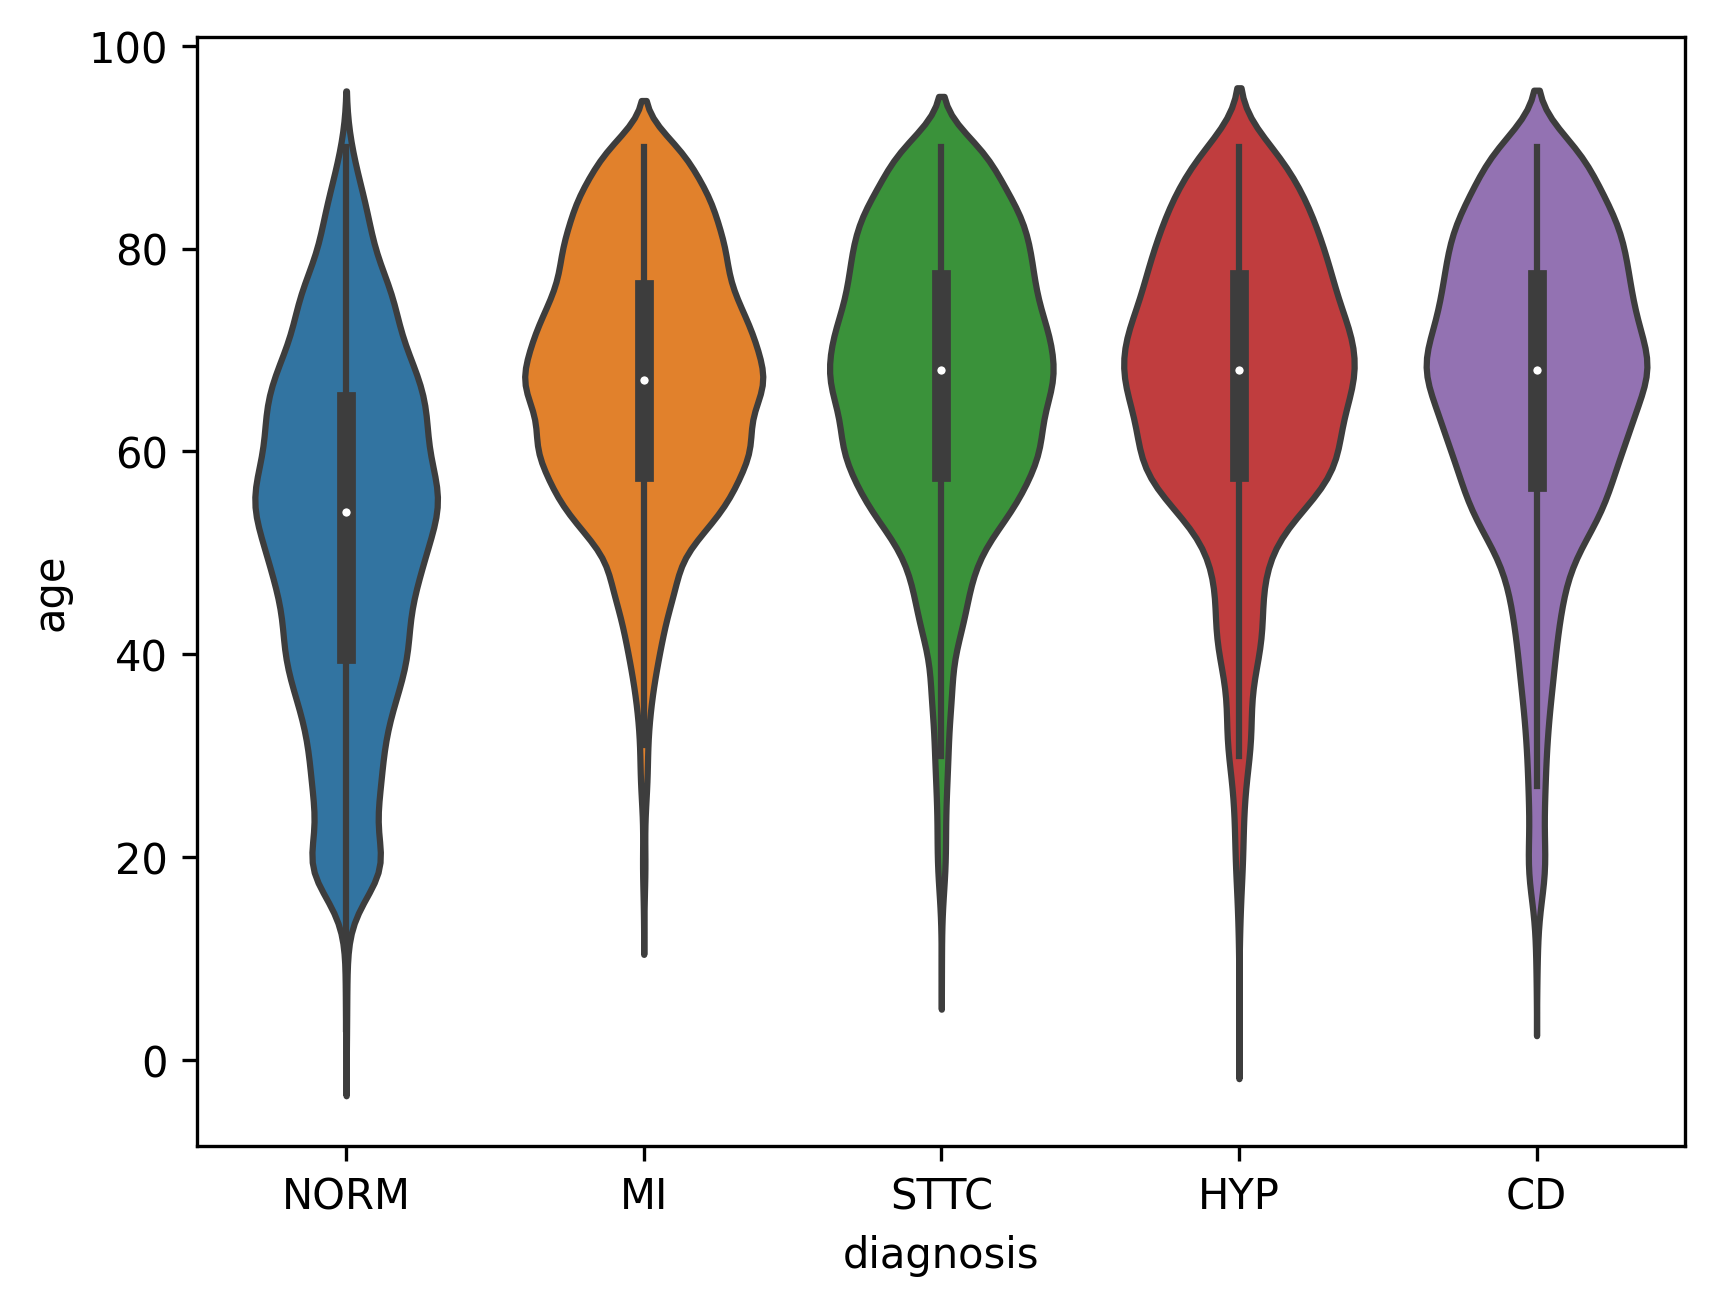

In [7]:
age_list, height_list, weight_list, diagnosis_list = [], [], [], []
for i, row in Y.iterrows():
    for value in row['diagnostic_superclass']:
        age_list.append(row['age'])
        height_list.append(row['height'])
        weight_list.append(row['weight'])
        diagnosis_list.append(value)

expanded_frame = pd.DataFrame({'age': age_list, 'height': height_list, 'weight': weight_list, 'diagnosis': diagnosis_list})
expanded_frame.loc[expanded_frame.age == 300, 'age'] = 90
sns.violinplot(expanded_frame, x='diagnosis', y='age');

In [8]:
height_table = expanded_frame[~expanded_frame.height.isna()]
weight_table = expanded_frame[~expanded_frame.weight.isna()]

for diagnosis in ['STTC', 'MI', 'CD', 'HYP']:
    norm = height_table.height[height_table.diagnosis == 'NORM']
    prob = height_table.height[height_table.diagnosis == diagnosis]
    pvalue = ttest_ind(norm, prob).pvalue
    print(f"Normal vs {diagnosis} height test p-value: {pvalue:.6f}")

print()

for diagnosis in ['STTC', 'MI', 'CD', 'HYP']:
    norm = weight_table.weight[weight_table.diagnosis == 'NORM']
    prob = weight_table.weight[weight_table.diagnosis == diagnosis]
    pvalue = ttest_ind(norm, prob).pvalue
    print(f"Normal vs {diagnosis} weight test p-value: {pvalue:.6f}")

Normal vs STTC height test p-value: 0.000002
Normal vs MI height test p-value: 0.065118
Normal vs CD height test p-value: 0.338170
Normal vs HYP height test p-value: 0.019416

Normal vs STTC weight test p-value: 0.000001
Normal vs MI weight test p-value: 0.330591
Normal vs CD weight test p-value: 0.035482
Normal vs HYP weight test p-value: 0.000007


# Diagnosis Classification: Introduction

In this section we will perform a multi-class classification task by separating individual heart beats, performing dimension reduction, kfold evaluation, and running an SVM classifier on the dataset.

## Diagnosis Classification: Import Statements

In [9]:
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
import neurokit2 as nk
from tqdm.notebook import tqdm
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler

## Diagnosis Classification: Helper Functions

In [10]:
def labelize_multiple(target):
    """
    Turn multi-class labels into one-hot encoding
    
    Parameters:
    target: list of list of target labels
    
    Returns:
    2D array of one-hot labels
    """

    unique = set()
    for values in target:
        unique.update(set(values))
    
    unique = sorted(list(unique))
    labelize = {v:i for i, v in enumerate(unique)}
    
    final = np.zeros([len(target), len(unique)], dtype=int)
    
    for i, values in enumerate(target):
        for item in values:
            final[i, labelize[item]] = 1
            
    return final, unique


def get_features(X, Y):
    """
    Isolate individual signals and save it in a list along with its target labels
    
    Parameters:
    X: 2D array of data with the shape of samples x features
    
    Y: 2D array of one-hot labels
    
    Returns:
    Extracted heartbeats and their corresponding labels
    """

    finalx, finaly = [], []
    for i, data in enumerate(tqdm(X)):
        peaks = find_peaks(data[:, 1])
        output = nk.ecg_segment(data[:, 1], rpeaks=peaks, sampling_rate=100)

        for _, value in output.items():
            temp = value.Signal.values
            array = np.zeros(85)
            end = min(85, len(temp))
            array[:end] = temp[:end]
            finalx.append(array)
            finaly.append(Y[i])
    return np.array(finalx), np.array(finaly)

## Diagnosis Classification: The Code

In [11]:
binary_labels, label_names = labelize_multiple(Y.diagnostic_superclass)
xdata, ydata = get_features(X, binary_labels)

for train_index, test_index in KFold().split(xdata):
    trainx = xdata[train_index]
    trainy = ydata[train_index]
    testx = xdata[test_index]
    testy = ydata[test_index]

    pca = PCA(n_components=20).fit(trainx)
    trainx, testx = pca.transform(trainx), pca.transform(testx)
    sca = MinMaxScaler().fit(trainx)
    trainx, testx = sca.transform(trainx), sca.transform(testx)
    predict = OneVsRestClassifier(LinearSVC()).fit(trainx, trainy).predict(testx)
    print((predict == testy).mean() * 100)

  0%|          | 0/21801 [00:00<?, ?it/s]

78.18499640593348
76.31798206204768
76.36209178088905
76.43724167224846
75.39004427308818


# Feature Visualization: Introduction

In this section, we will visualize the feature space of the extracted features from the previous section.

## Feature Visualization: Import Statements

In [12]:
from umap import UMAP

## Feature Visalization: The Code

(306056, 3)


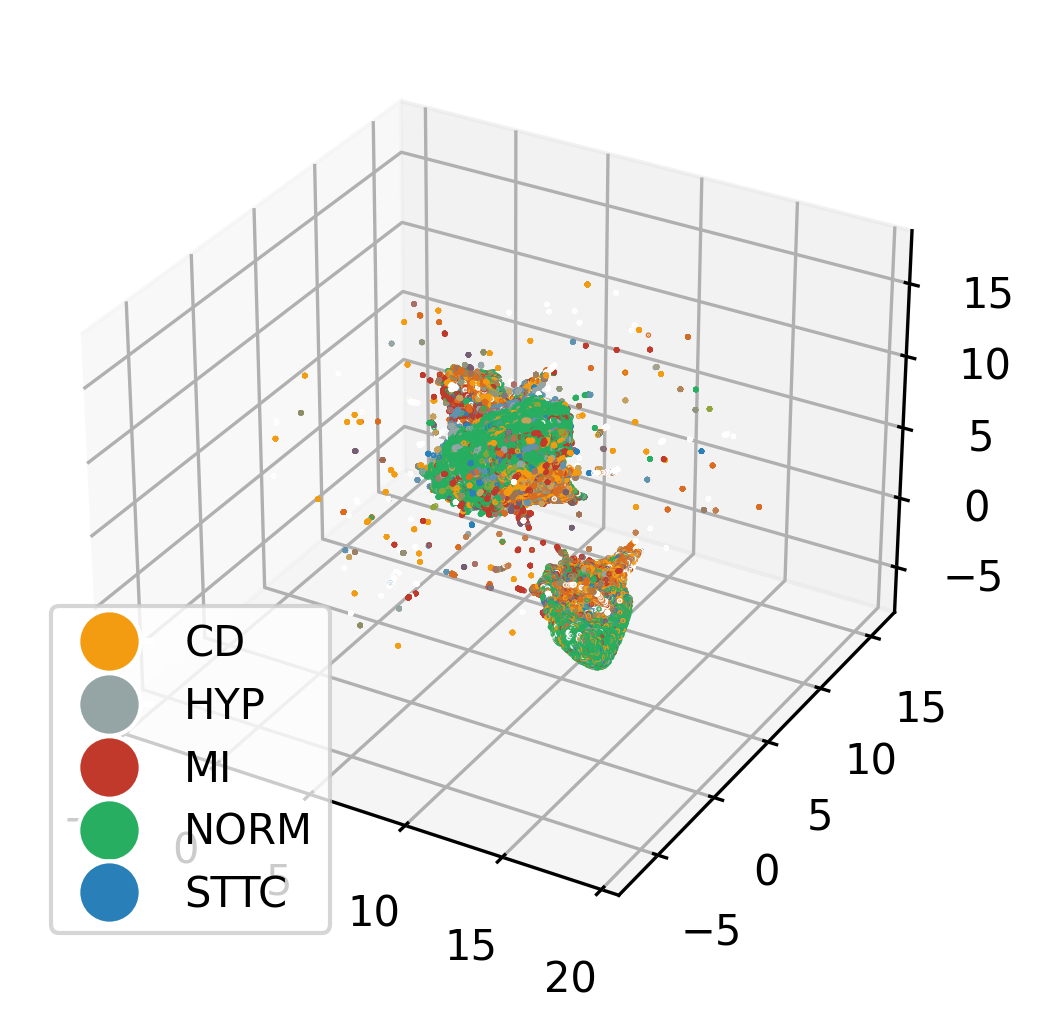

In [13]:
transformed_data = UMAP(n_components=3).fit_transform(xdata)
print(transformed_data.shape)

def combine_colors(colors):
    """
    Combine a list of colors to get a color in between
    # REF: https://stackoverflow.com/questions/61488790/how-can-i-proportionally-mix-colors-in-python
    
    Parameters:
    colors: 2D array of colors with each color in each row
    
    Returns:
    The combined final color
    """

    if len(colors) <= 0: return [1, 1, 1]
    return colors.mean(axis=0)

blue, red, yellow, green, dark = [41, 128, 185], [192, 57, 43], [243, 156, 18], [39, 174, 96], [149, 165, 166]
color_list = np.array([yellow, dark, red, green, blue]) / 255

final_colors = []
for line in ydata:
    c = combine_colors(color_list[line.astype(bool), :])
    final_colors.append(c)

final_colors = np.array(final_colors)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), subplot_kw={'projection': '3d'})
ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], c=final_colors, s=.1, alpha=1)

points = []
for i, color in enumerate(color_list):
    points.append(Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor=color, markersize=15))
ax.legend(points, label_names);